In [7]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2Tokenizer

class IDEALTranslator(nn.Module):
    def __init__(
        self,
        gpt2_vocab_size=50257,
        idea_token_vocab_size=1024,
        hidden_size=768,
        num_encoder_layers=6,
        num_decoder_layers=6
    ):

        super().__init__()

        # Model 1: GPT2 tokens to idea tokens
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_size,
                nhead=8,
                dim_feedforward=3072,
                batch_first=True
            ),
            num_layers=num_encoder_layers
        )

        self.to_idea_tokens = nn.Linear(hidden_size, idea_token_vocab_size) # Currently it's one to one

        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=hidden_size,
                nhead=8,
                dim_feedforward=3072,
                batch_first=True
            ),
            num_layers=num_decoder_layers
        )

        self.to_gpt2 = nn.Linear(hidden_size, gpt2_vocab_size)

        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

        # Token embeddings
        self.gpt2_embeddings = nn.Embedding(gpt2_vocab_size, hidden_size)
        self.idea_embeddings = nn.Embedding(idea_token_vocab_size, hidden_size)

        self.tau = 0.5

    def forward(self, source_tokens, padding_mask, target_tokens=None):
      src_embeddings = self.gpt2_embeddings(source_tokens)
      embeddings = self.encoder(src_embeddings, src_key_padding_mask=padding_mask)

      idea_logits = self.to_idea_tokens(embeddings)
      self.tau *= 0.999
      idea_tokens = F.gumbel_softmax(idea_logits, tau=self.tau, hard=True, dim=-1)
      idea_embeddings = torch.matmul(idea_tokens, self.idea_embeddings.weight)

      if self.training:
          # Find first EOS token position in target
          eos_positions = (target_tokens == self.tokenizer.eos_token_id).float()
          # If no EOS found, use sequence length
          eos_positions = torch.where(
              eos_positions.sum(dim=1) == 0,  # If no EOS found
              torch.ones_like(eos_positions[:,0]) * target_tokens.size(1),  # Use sequence length
              eos_positions.argmax(dim=1)  # Otherwise use first EOS position
          )
          sequence_mask = torch.arange(target_tokens.size(1), device=target_tokens.device)[None, :] <= eos_positions[:, None]

          # Only use target tokens up to EOS
          masked_target = target_tokens * sequence_mask.long()
          tgt_embedded = self.gpt2_embeddings(masked_target)

          decoder_output = self.decoder(
              tgt_embedded,
              idea_embeddings,
              tgt_mask=self.generate_square_subsequent_mask(masked_target.size(1)).to(tgt_embedded.device),
              memory_key_padding_mask=padding_mask
          )

          # Debug print
          if random.random() > 0.96:
              pred_tokens = self.to_gpt2(decoder_output).argmax(dim=-1)[0]
              first_eos = (pred_tokens == self.tokenizer.eos_token_id).nonzero(as_tuple=True)[0]
              if len(first_eos) > 0:  # If we found an EOS token
                  pred_tokens = pred_tokens[:first_eos[0]]

              # Get source tokens up to first EOS
              src_tokens = source_tokens[0]
              src_first_eos = (src_tokens == self.tokenizer.eos_token_id).nonzero(as_tuple=True)[0]
              if len(src_first_eos) > 0:  # If we found an EOS token
                  src_tokens = src_tokens[:src_first_eos[0]]

              print(self.tokenizer.decode(src_tokens), " | ",
                    self.tokenizer.decode(pred_tokens))
      else:
          decoder_output = self.generate(idea_embeddings, padding_mask)

      output_logits = self.to_gpt2(decoder_output)
      return output_logits, idea_tokens
    def generate(self, idea_embeddings, padding_mask, max_length=100):
        # print("\nGENERATION DEBUG:")
        batch_size = idea_embeddings.size(0)
        device = idea_embeddings.device

        # Start with start token
        current_token = torch.ones(batch_size, 1).long().to(device) * self.tokenizer.bos_token_id

        generated_sequence = current_token
        decoded_tokens = []

        for i in range(max_length):
            tgt_embed = self.gpt2_embeddings(generated_sequence)
            # print(f"Step {i}, sequence length: {generated_sequence.size(1)}")

            tgt_mask = self.generate_square_subsequent_mask(generated_sequence.size(1)).to(device)
            decoder_output = self.decoder(
                tgt_embed,
                idea_embeddings,
                tgt_mask=tgt_mask,
                memory_key_padding_mask=padding_mask
            )

            # Get logits for next token
            logits = self.to_gpt2(decoder_output[:, -1:])

            # Add temperature
            logits = logits / 0.7

            # Get probabilities
            probs = F.softmax(logits, dim=-1)

            # Get next token
            next_token = torch.argmax(probs, dim=-1)
            # print(f"Generated token: {next_token.item()}, prob: {probs[0,0,next_token.item()].item():.4f}")

            generated_sequence = torch.cat([generated_sequence, next_token], dim=1)
            decoded_tokens.append(next_token.item())

            # Stop if we hit the end token
            if next_token.item() == self.tokenizer.eos_token_id:
                print("Hit end token, stopping generation")
                break

        print(f"Final sequence length: {generated_sequence.size(1)}")
        print(f"Generated tokens: {self.tokenizer.decode(decoded_tokens)}")

        return decoder_output
    @staticmethod
    def generate_square_subsequent_mask(sz):
        mask = torch.triu(torch.ones(sz, sz)) == 1
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf'))
        return mask


class StandardTransformer(nn.Module):
    def __init__(
        self,
        gpt2_vocab_size=50257,
        hidden_size=768,
        num_layers=12,  # Combined encoder/decoder layers
    ):
        super().__init__()

        self.embedding = nn.Embedding(gpt2_vocab_size, hidden_size)

        # Single transformer instead of separate encoder/decoder
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=8,
            num_encoder_layers=num_layers//2,
            num_decoder_layers=num_layers//2,
            dim_feedforward=3072,
            batch_first=True
        )

        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.output_projection = nn.Linear(hidden_size, gpt2_vocab_size)

    def forward(self, source_tokens, padding_mask, target_tokens=None):
        src_embeddings = self.embedding(source_tokens)

        if self.training:
            tgt_embeddings = self.embedding(target_tokens)
            tgt_mask = self.generate_square_subsequent_mask(target_tokens.size(1)).to(source_tokens.device)

            output = self.transformer(
                src_embeddings,
                tgt_embeddings,
                src_key_padding_mask=padding_mask,
                tgt_mask=tgt_mask
            )
        else:
            output = self.generate(src_embeddings, padding_mask)

        if random.random() > 0.96:
          print(self.tokenizer.decode(source_tokens[0]), " | ", self.tokenizer.decode(self.output_projection(output[0]).argmax(dim=-1)))
        return self.output_projection(output), None  # None to match IDEAL's return signature

    @staticmethod
    def generate_square_subsequent_mask(sz):
        mask = torch.triu(torch.ones(sz, sz)) == 1
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf'))
        return mask

    def generate(self, src_embeddings, padding_mask, max_length=100):
        batch_size = src_embeddings.size(0)
        device = src_embeddings.device

        # Start with start token
        current_token = torch.ones(batch_size, 1).long().to(device) * 50256  # EOS token for GPT2

        generated_sequence = current_token

        for i in range(max_length):
            # Embed current sequence
            tgt_embed = self.embedding(generated_sequence)

            # Create causal mask
            tgt_mask = self.generate_square_subsequent_mask(generated_sequence.size(1)).to(device)

            # Run through transformer
            decoder_output = self.transformer(
                src_embeddings,
                tgt_embed,
                src_key_padding_mask=padding_mask,
                tgt_mask=tgt_mask
            )

            # Get next token probabilities
            logits = self.output_projection(decoder_output[:, -1:])
            probs = F.softmax(logits / 0.7, dim=-1)  # Add temperature

            # Select next token
            next_token = torch.argmax(probs, dim=-1)

            # Add to sequence
            generated_sequence = torch.cat([generated_sequence, next_token], dim=1)

            # print(f"Step {i}, Generated token: {next_token.item()}, prob: {probs[0,0,next_token.item()].item():.4f}")

            # Stop if we hit EOS
            if next_token.item() == 50256:
                break

        return decoder_output

In [8]:
try:
  from datasets import load_dataset
except:
  !pip install datasets
  from datasets import load_dataset

from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2Tokenizer
from torch.optim import Adam

# Load dataset
dataset = load_dataset("opus100", "en-fr", split="train[:10000]")

class TranslationDataset(Dataset):
   def __init__(self, dataset, tokenizer):
       self.dataset = dataset
       self.tokenizer = tokenizer

   def __len__(self):
       return len(self.dataset)

   def __getitem__(self, idx):
       item = self.dataset[idx]
       return {
           'source': item['translation']['fr'],
           'target': item['translation']['en']
       }

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# Initialize models
ideal_model = IDEALTranslator().to(device)
standard_model = StandardTransformer().to(device)

# Optimizers
ideal_optimizer = Adam(ideal_model.parameters(), lr=1e-4)
standard_optimizer = Adam(standard_model.parameters(), lr=1e-4)

# Dataset and loader
train_dataset = TranslationDataset(dataset, gpt2_tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

global flip_bit
flip_bit = -1
global ideal_train_loss_ls
ideal_train_loss_ls = []
global transformer_train_loss_ls
transformer_train_loss_ls = []
def train_epoch(model, optimizer, is_ideal=True):
   model.train()
   total_loss = 0

   global flip_bit
   global ideal_train_loss_ls
   global transformer_train_loss_ls

   flip_bit += 1


   for batch_idx, batch in enumerate(train_loader):
       optimizer.zero_grad()

       # Process input
       source_tokens = gpt2_tokenizer(
           batch['source'],
           return_tensors='pt',
           padding=True,
           truncation=True,
           max_length=512
       ).input_ids.to(device)

       target_tokens = gpt2_tokenizer(
           batch['target'],
           return_tensors='pt',
           padding=True,
           truncation=True,
           max_length=512
       ).input_ids.to(device)

       padding_mask = (source_tokens == gpt2_tokenizer.pad_token_id).to(device)

       # Forward pass
       output_logits, idea_tokens = model(source_tokens, padding_mask, target_tokens)

       # Loss computation
       translation_loss = F.cross_entropy(
            output_logits.view(-1, output_logits.size(-1)),
            target_tokens.view(-1),
            ignore_index=gpt2_tokenizer.pad_token_id,
            reduction='none'
       )

        # Create mask up to first EOS in target (not including padding)
       target_lens = target_tokens.ne(gpt2_tokenizer.pad_token_id).sum(1)
       mask = torch.arange(target_tokens.size(1), device=device)[None, :] < target_lens[:, None]

        # Average loss over actual tokens only
       valid_loss = (translation_loss.view(target_tokens.shape) * mask).sum()
       num_tokens = mask.sum()
       avg_loss = valid_loss / num_tokens

       if is_ideal:
            entropy_loss = -torch.mean(torch.sum(
                idea_tokens * torch.log(idea_tokens + 1e-10),
                dim=-1
            ))
            batch_loss = avg_loss + 0.01 * entropy_loss  # Reduced entropy weight
       else:
            batch_loss = avg_loss
       total_loss += batch_loss.item()

       # Backward pass
       batch_loss.backward()
       optimizer.step()

       if batch_idx % 200 == 0:
           print(f'Batch {batch_idx}, Loss: {batch_loss.item():.4f}')
           if flip_bit % 2 == 1:
              transformer_train_loss_ls.append(batch_loss.item())
           else:
              ideal_train_loss_ls.append(batch_loss.item())

   return total_loss / len(train_loader)

def evaluate(model, text, is_ideal=True):
   model.eval()
   with torch.no_grad():
       source_tokens = gpt2_tokenizer(
           text,
           return_tensors='pt',
           padding=True
       ).input_ids.to(device)

       padding_mask = (source_tokens == gpt2_tokenizer.pad_token_id).to(device)
       output_logits, _ = model(source_tokens, padding_mask)
       predicted_tokens = torch.argmax(output_logits, dim=-1)
       return gpt2_tokenizer.decode(predicted_tokens[0], skip_special_tokens=True)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
   print(f"\nEpoch {epoch+1}/{num_epochs}")

   # Train IDEAL
   ideal_loss = train_epoch(ideal_model, ideal_optimizer, is_ideal=True)
   print(f"IDEAL Average Loss: {ideal_loss:.4f}")

   # Train Standard Transformer
   standard_loss = train_epoch(standard_model, standard_optimizer, is_ideal=False)
   print(f"Standard Average Loss: {standard_loss:.4f}")

   # Save checkpoints
   if epoch % 5 == 0:
       torch.save({
           'epoch': epoch,
           'ideal_model': ideal_model.state_dict(),
           'standard_model': standard_model.state_dict(),
           'ideal_optimizer': ideal_optimizer.state_dict(),
           'standard_optimizer': standard_optimizer.state_dict(),
           'ideal_loss': ideal_loss,
           'standard_loss': standard_loss,
       }, f'checkpoint_epoch_{epoch}.pt')

# Test translations
test_fr = "Bonjour, comment allez-vous?"
print("\nTest Translations:")
print(f"French: {test_fr}")
print(f"IDEAL: {evaluate(ideal_model, test_fr, is_ideal=True)}")
print(f"Standard: {evaluate(standard_model, test_fr, is_ideal=False)}")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Epoch 1/5
Batch 0, Loss: 11.0923
- Parce que tu passes de la drogue.  |  I to in,. the.. you.--..................-... you----
Tu as eu une autre absence, Norman.  |  You had on on,-. the!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Un traité sur le commerce des armes se fonderait sur les accords régionaux et multilatéraux sur la réglementation des transferts d'armes et sur les principes applicables en la matière déjà adoptés.  |  . I tradeThe would were there beAnd and out my. and. on the control of/ to. the!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Batch 200, Loss: 5.1191
Les stocks de fin de campagne baisseraient pour donner un rapport s-u de 43 %.  |   in is for to increase for all for, see between!i,. some!i and thati.
Le voilà.  |  , he on. the!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Donnez-moi 5 minutes.  |   been (S the you one, F the) if me about had minutes. the!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Sérieux... Il a cru que je disais quoi?  |   a on

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Final sequence length: 101
Generated tokens:  the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
IDEAL:  the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Standard:  Ben powerful powerful powerful powerful powerful powerful powerful powerful powerful powerful powerful powerful powerful powerful power

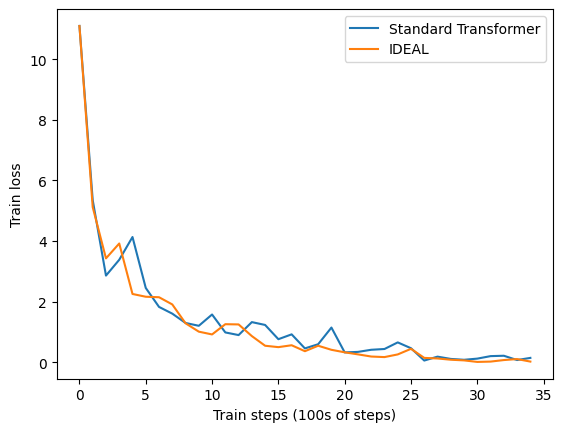

In [16]:
import matplotlib.pyplot as plt

plt.xlabel("Train steps (100s of steps)")
plt.ylabel("Train loss")
plt.plot(transformer_train_loss_ls, label="Standard Transformer")
plt.plot(ideal_train_loss_ls, label="IDEAL")
plt.legend()

In [ ]:
IDEAL
- Réception de son Eminence le Cheikh Akl de la Communauté des Unitariens Druzes, le Cheikh Naim Hassan de l’Ambassadrice de Bretagne au Liban, Francis Mary Guy, le 2 juin 2011
- Reception of his Eminence the Sheikh Akl of the Druze Unitarian Community for the British Ambassador to Lebanon Frances Mary Guy, on June 2, 2011


3.16 fabricant : personne ou organisme responsable de la conception, de la fabrication et des essais effectués sur les bouteilles
3.16. manufacturer: The person or organization responsible for the design, fabrication and testing of the cylinders.
